<a href="https://colab.research.google.com/github/zahabkf/Stroke_Prediction/blob/main/Stroke_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


In [ ]:
import io

data = pd.read_csv(io.BytesIO(uploaded['healthcare-dataset-stroke-data.csv']))
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
print(data.shape)

(5110, 12)


#Feature Extraction

In [ ]:
import numpy as np
columns_to_drop = ['id', 'Residence_type', 'work_type','ever_married']
data = data.drop(columns_to_drop,axis=1)
data.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,202.21,NaN,never smoked,1
2,Male,80.0,0,1,105.92,32.5,never smoked,1
3,Female,49.0,0,0,171.23,34.4,smokes,1
4,Female,79.0,1,0,174.12,24.0,never smoked,1


In [ ]:
data = data.replace('Unknown',np.NaN)

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of missing values:
	gender: 0
	age: 0
	hypertension: 0
	heart_disease: 0
	avg_glucose_level: 0
	bmi: 201
	smoking_status: 1544
	stroke: 0


#Replacing Null/missing values


In [ ]:
data2 = data['bmi']
data2 = data2.fillna(data2.median())

data['bmi'] = data2

In [ ]:
mode_value = data['smoking_status'].mode()[0]

#Fill missing values with mode
data['smoking_status'].fillna(mode_value, inplace=True)

In [ ]:
print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Number of missing values:
	gender: 0
	age: 0
	hypertension: 0
	heart_disease: 0
	avg_glucose_level: 0
	bmi: 0
	smoking_status: 0
	stroke: 0


In [ ]:
data['stroke'] = ['Stroke' if i == 1 else 'Normal' for i in data['stroke']]

#EDA (exploratory data analysis)


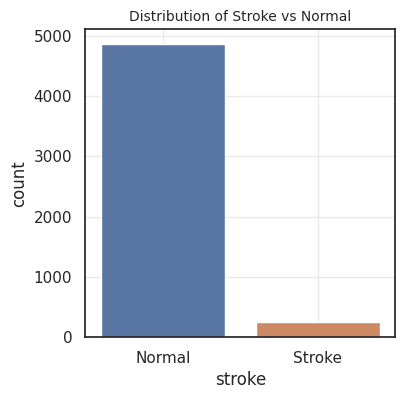

In [ ]:
# distribution of the label `stroke`
plt.figure(figsize=(4,4))
sns.countplot(data=data, x='stroke')
plt.title('Distribution of Stroke vs Normal', fontsize=10)
plt.grid(alpha=0.4)
plt.show()

Since our data is heavily imbalanced, we will balance it using overSampling

In [ ]:

# Count the number of rows with stroke = 1 and stroke = 0
stroke_count = data[data['stroke'] == 'Stroke'].shape[0]
Normal_count = data[data['stroke'] == 'Normal'].shape[0]

# Find the difference in counts and duplicate rows with stroke = 1
diff_count = Normal_count - stroke_count
rows_to_duplicate = data[data['stroke'] == 'Stroke'].sample(n=diff_count, replace=True)

# Concatenate the duplicated rows with the original dataframe
data = pd.concat([data, rows_to_duplicate], ignore_index=True)

# Shuffle the DataFrame to mix the duplicated rows
data = data.sample(frac=1).reset_index(drop=True)


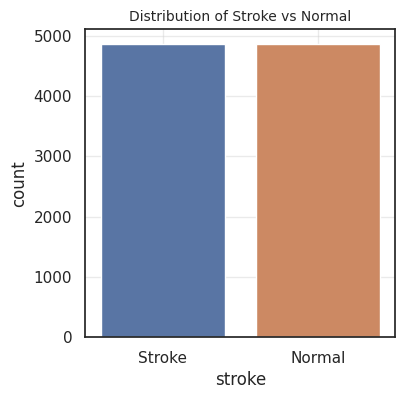

In [ ]:
# distribution of the label `stroke`
plt.figure(figsize=(4,4))
sns.countplot(data=data, x='stroke')
plt.title('Distribution of Stroke vs Normal', fontsize=10)
plt.grid(alpha=0.4)
plt.show()


In [ ]:
print('Number of rows after balancing:', data.shape)

Number of rows after balancing: (9722, 8)


In [ ]:
pd.crosstab([data['smoking_status']],data['stroke'])

stroke,Normal,Stroke
smoking_status,,
formerly smoked,815,1404
never smoked,3299,2643
smokes,747,814


In [ ]:
pd.crosstab([data['hypertension']],data['stroke'])

stroke,Normal,Stroke
hypertension,,
0,4429,3557
1,432,1304


In [ ]:
pd.crosstab([data['hypertension'], data["smoking_status"]],data['stroke'])

stroke                        Normal  Stroke
hypertension smoking_status                 
0            formerly smoked     714    1015
             never smoked       3051    1955
             smokes              664     587
1            formerly smoked     101     389
             never smoked        248     688
             smokes               83     227

In [ ]:
pd.crosstab([data['avg_glucose_level']],data['stroke'])

stroke,Normal,Stroke
avg_glucose_level,,
55.12,1,0
55.22,1,0
55.23,1,0
55.25,1,0
55.26,1,0
...,...,...
266.59,1,0
267.60,1,0
267.61,1,0


<ipython-input-195-bf378b71b848>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


                        age  hypertension  heart_disease  avg_glucose_level  \
age                1.000000      0.275558       0.264757           0.267233   
hypertension       0.275558      1.000000       0.088564           0.169590   
heart_disease      0.264757      0.088564       1.000000           0.241971   
avg_glucose_level  0.267233      0.169590       0.241971           1.000000   
bmi                0.173392      0.119367       0.042532           0.234358   

                        bmi  
age                0.173392  
hypertension       0.119367  
heart_disease      0.042532  
avg_glucose_level  0.234358  
bmi                1.000000  


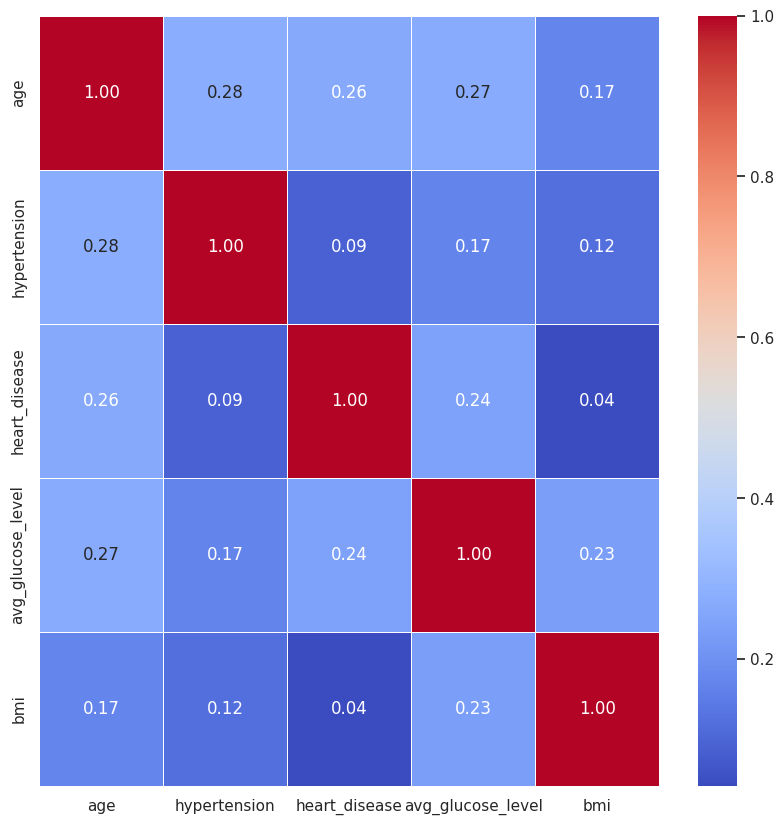

In [ ]:
correlation_matrix = data.corr()
print(correlation_matrix)

sns.set(style="white")  # Set the style of the visualization
plt.figure(figsize=(10, 10))

# Creating a heatmap with a color map
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)


plt.show()

#Outlier handling

In [ ]:
columns_to_standardize = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
data[columns_to_standardize] = scaler.fit_transform(data[columns_to_standardize])

<Axes: >

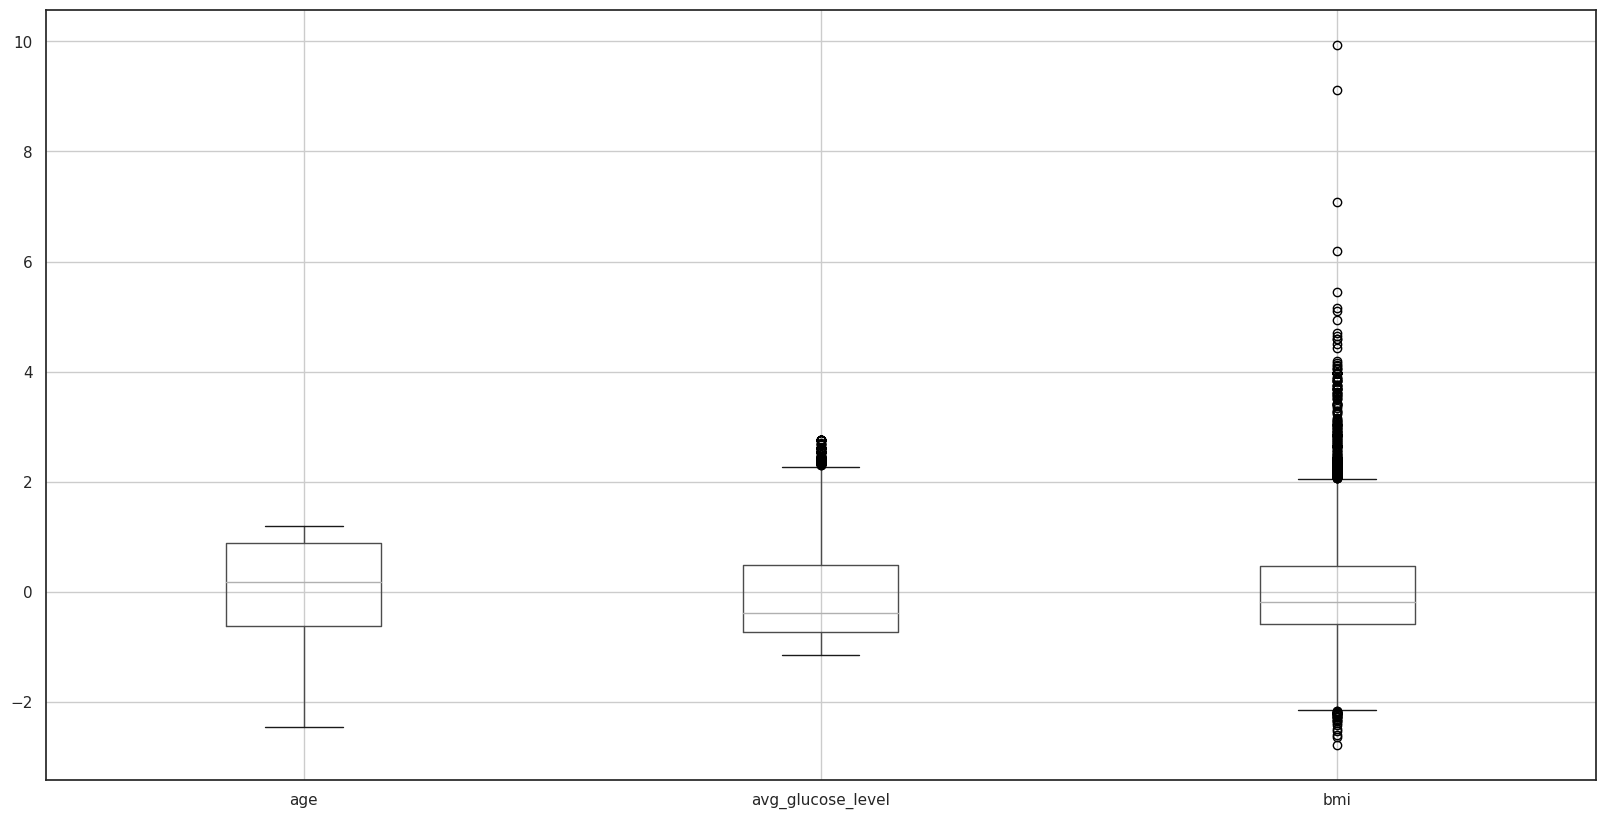

In [ ]:
%matplotlib inline

data2 = data.drop(['stroke','hypertension','heart_disease'],axis=1)
data2.boxplot(figsize=(20, 10))

In [ ]:
columns_to_check = ['age', 'avg_glucose_level', 'bmi']

# Calculate Z-scores for the specified columns
z_scores = np.abs(stats.zscore(data[columns_to_check]))

# Set a threshold for Z-scores (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers = (z_scores > threshold).any(axis=1)

# Display only the values of the outliers in the specified columns
outlier_values = data.loc[outliers, columns_to_check]
print("Outlier Values:")
print(outlier_values)

Outlier Values:
           age  avg_glucose_level       bmi
29    0.487425          -0.550792  3.413991
35    0.487425           1.562069  3.399422
95   -1.074467          -0.527891  3.282867
247  -0.449710           1.906308  3.967624
300   0.844429           1.577036  3.676238
...        ...                ...       ...
9334 -0.271208           1.756819  4.186164
9362 -0.583587          -0.525907  3.559684
9472 -0.449710           1.906308  3.967624
9520 -1.699224          -0.911982  3.836501
9589  0.085796           0.201161  4.594104

[93 rows x 3 columns]


Can see that bmi attribute has some outliers

In [ ]:
print('Number of rows before removing outliers = ', (data.shape[0]))
data = data.drop(data[outliers].index)
print('Number of rows after removing outliers = ', (data.shape[0]))

Number of rows before removing outliers =  9722
Number of rows after removing outliers =  9629


In [ ]:
original_data = scaler.inverse_transform(data[columns_to_standardize])

# Replace the standardized columns in the dataset with the original values
data[columns_to_standardize] = original_data

# Decision tree classifier

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=122)

# print the dimension of the training and testing dataset
print(train.shape)
print(test.shape)

x_train = train.drop(columns=['stroke'], axis=1)
y_train = train['stroke']

(7703, 8)
(1926, 8)


In [ ]:

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

column_transformer = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9),['gender','smoking_status']),remainder='passthrough')

transformed_x_train = column_transformer.fit_transform(x_train)

# get the feature names of the transform data
features = column_transformer.get_feature_names_out()

# convert the output numpy array from the transformation to a pandas dataframe
transformed_df = pd.DataFrame(transformed_x_train, columns=features)

In [ ]:

from sklearn.tree import DecisionTreeClassifier

# instantize a DecisionTreeClassifier class
clf = DecisionTreeClassifier(max_depth=3)

# train the classification model with training data
clf.fit(transformed_df, y_train)

X_test = test.drop(columns=['stroke'], axis=1)
y_test = test['stroke']

# transform the categorical features
transformed_x_test = column_transformer.transform(X_test)

# get the feature names of the transform data
features = column_transformer.get_feature_names_out()

# convert the output numpy array from the transformation to a pandas dataframe
transformed_Xtest = pd.DataFrame(transformed_x_test, columns=features)

y_pred = clf.predict(transformed_Xtest)

# Evaluate the model
print("Accuracy of model with test data:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy of model with test data: 0.7564901349948079
Confusion Matrix:
 [[644 309]
 [160 813]]


In [ ]:
transformed_Xtrain = pd.DataFrame(transformed_x_train, columns=features)
train_y_pred = clf.predict(transformed_Xtrain)
print("Accuracy of model with train data:", accuracy_score(y_train, train_y_pred))

Accuracy of model with train data: 0.7798260418018954


[Text(0.5, 0.875, 'node #0\nremainder__age <= 55.5\ngini = 0.5\nsamples = 7703\nvalue = [3830, 3873]\nclass = Stroke'),
 Text(0.25, 0.625, 'node #1\nremainder__age <= 44.5\ngini = 0.279\nsamples = 3208\nvalue = [2671, 537]\nclass = Normal'),
 Text(0.125, 0.375, 'node #2\nremainder__avg_glucose_level <= 58.115\ngini = 0.129\nsamples = 2157\nvalue = [2008, 149]\nclass = Normal'),
 Text(0.0625, 0.125, 'node #3\ngini = 0.469\nsamples = 93\nvalue = [58, 35]\nclass = Normal'),
 Text(0.1875, 0.125, 'node #4\ngini = 0.104\nsamples = 2064\nvalue = [1950, 114]\nclass = Normal'),
 Text(0.375, 0.375, 'node #5\nremainder__bmi <= 27.25\ngini = 0.466\nsamples = 1051\nvalue = [663, 388]\nclass = Normal'),
 Text(0.3125, 0.125, 'node #6\ngini = 0.227\nsamples = 237\nvalue = [206, 31]\nclass = Normal'),
 Text(0.4375, 0.125, 'node #7\ngini = 0.492\nsamples = 814\nvalue = [457, 357]\nclass = Normal'),
 Text(0.75, 0.625, 'node #8\nremainder__age <= 73.5\ngini = 0.383\nsamples = 4495\nvalue = [1159, 3336]\nc

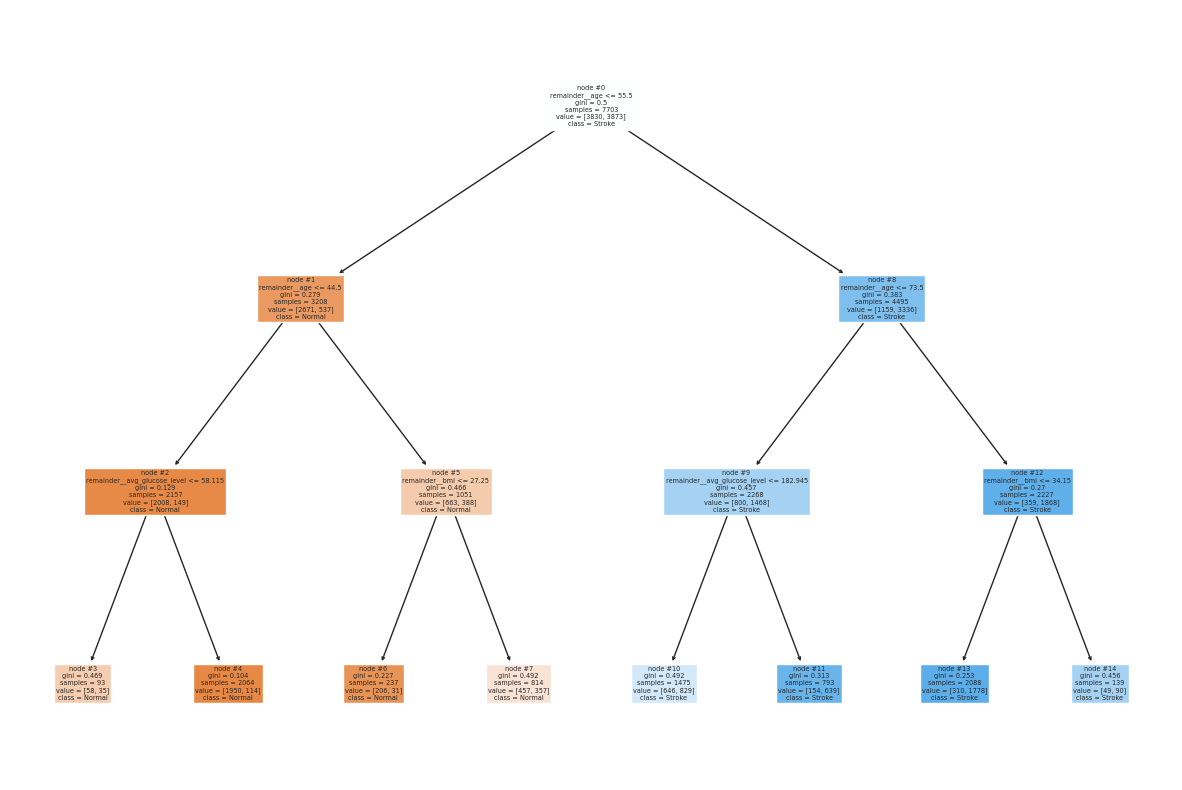

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(clf, feature_names=transformed_df.columns.tolist(), class_names=y_train.unique().tolist(), filled=True, node_ids=True)

#KNN Model

In [ ]:
# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # You can adjust the number of neighbors as needed

# Fit the classifier on the training data
knn.fit(transformed_df, y_train)

# Make predictions on the test data
y_pred = knn.predict(transformed_Xtest)

# Evaluate the model
print("Accuracy of model with test data:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy of model with test data: 0.9558670820353063
Confusion Matrix:
 [[868  85]
 [  0 973]]


In [ ]:
plt.figure(figsize=(8, 6))

# Plot the points from transformed_Xtest
plt.scatter(transformed_Xtest[:, 0], transformed_Xtest[:, 1], c=y_pred, cmap='viridis', label='Predicted')
# Assuming transformed_Xtest has 2 dimensions; adjust the indexing if your data has more dimensions

# Plot the points from transformed_df
plt.scatter(transformed_df[:, 0], transformed_df[:, 1], c=y_train, cmap='viridis', marker='x', label='Training Data')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KNN Predictions vs. Training Data')
plt.legend()
plt.colorbar(label='Predicted Class')
plt.show()

In [ ]:
train_y_pred = knn.predict(transformed_Xtrain)
print("Accuracy of model with train data:", accuracy_score(y_train, train_y_pred))

Accuracy of model with train data: 0.97286771387771


#Random Forest Classification Model (Ensemble Learning)


In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier on the training data
rf_classifier.fit(transformed_df, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(transformed_Xtest)

# Evaluate the model
print("Accuracy of model with test data:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy of model with test data: 0.9885773624091381
Confusion Matrix:
 [[931  22]
 [  0 973]]


In [ ]:
train_y_pred = rf_classifier.predict(transformed_Xtrain)
print("Accuracy of model with trained data:", accuracy_score(y_train, train_y_pred))

Accuracy of model with trained data: 1.0


#Overfitting with Decision Trees

In [ ]:
odt = DecisionTreeClassifier(max_depth=42)

# train the classification model with training data
odt.fit(transformed_df, y_train)

DecisionTreeClassifier(max_depth=42)

[Text(0.39013135302197804, 0.9814814814814815, 'node #0\nremainder__age <= 55.5\ngini = 0.5\nsamples = 7703\nvalue = [3830, 3873]\nclass = Stroke'),
 Text(0.07875457875457875, 0.9444444444444444, 'node #1\nremainder__age <= 44.5\ngini = 0.279\nsamples = 3208\nvalue = [2671, 537]\nclass = Normal'),
 Text(0.027014652014652016, 0.9074074074074074, 'node #2\nremainder__avg_glucose_level <= 58.115\ngini = 0.129\nsamples = 2157\nvalue = [2008, 149]\nclass = Normal'),
 Text(0.007326007326007326, 0.8703703703703703, 'node #3\nremainder__avg_glucose_level <= 57.925\ngini = 0.469\nsamples = 93\nvalue = [58, 35]\nclass = Normal'),
 Text(0.003663003663003663, 0.8333333333333334, 'node #4\ngini = 0.0\nsamples = 53\nvalue = [53, 0]\nclass = Normal'),
 Text(0.01098901098901099, 0.8333333333333334, 'node #5\nordinalencoder__gender <= 0.5\ngini = 0.219\nsamples = 40\nvalue = [5, 35]\nclass = Stroke'),
 Text(0.007326007326007326, 0.7962962962962963, 'node #6\nremainder__bmi <= 26.7\ngini = 0.102\nsample

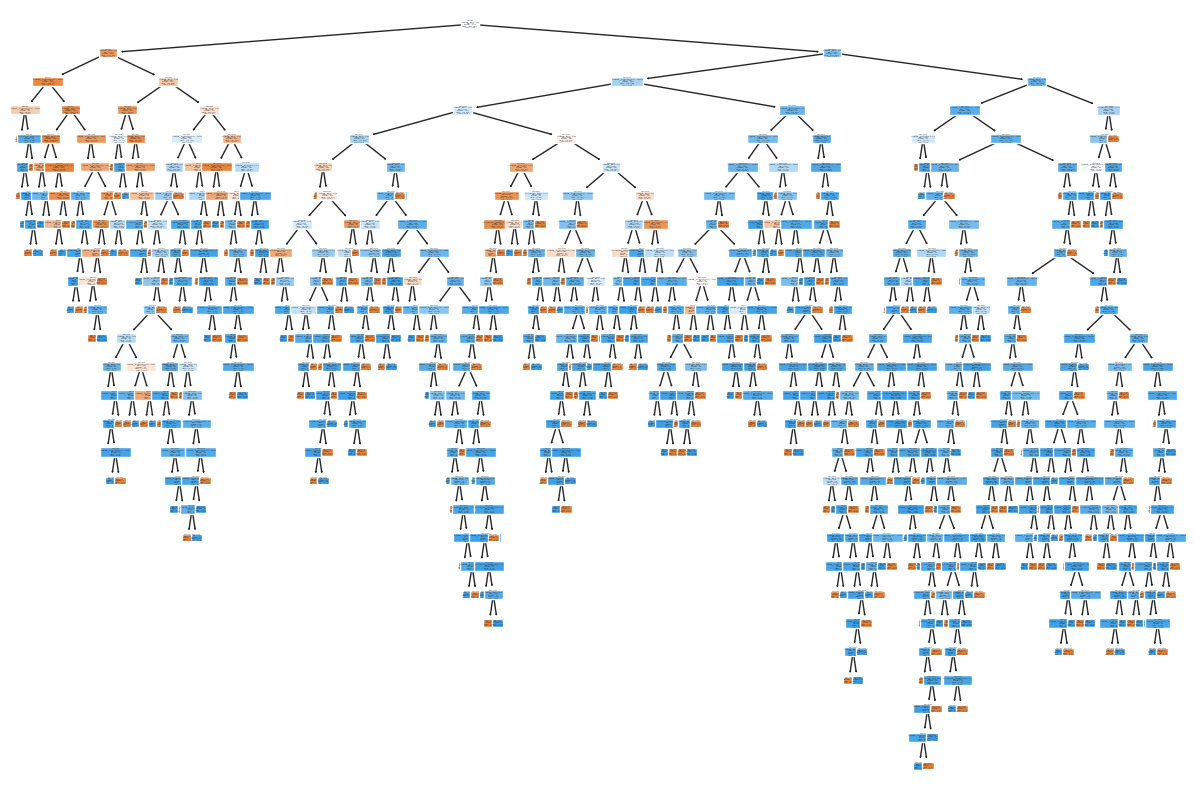

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(odt, feature_names=transformed_df.columns.tolist(), class_names=y_train.unique().tolist(), filled=True, node_ids=True)

In [ ]:
y_pred = odt.predict(transformed_Xtest)

# Evaluate the model
print("Accuracy of model with test data:", accuracy_score(y_test, y_pred))

Accuracy of model with test data: 0.9719626168224299


#Accuracy score of model fitted with trained data

In [ ]:
train_y_pred = odt.predict(transformed_Xtrain)
print("Accuracy of model with trained data:", accuracy_score(y_train, train_y_pred))

Accuracy of model with trained data: 1.0
